<a href="https://colab.research.google.com/github/Krotonus/Multimodal-Workshop/blob/main/maze_game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maze Solving using Prompts

The goal of this exercise is to write a prompt that can solve the movement of an AI in a grid world using prompting. You need to avoid walls, pick up a key, and then reach the goal.

In [1]:
from google.colab import userdata
ai_key = userdata.get('GOOGLE_API_KEY')

MODEL_NAME = "gemini-2.0-flash"

In [2]:
#@title Install (collapse me)
%%capture
!sudo apt-get install libcairo2-dev
!pip install -q -U git+https://github.com/chalk-diagrams/chalk openai google-genai pycairo tiktoken

This cell can be ignored. It just imports the necessary libraries and sets up a prompt call.


In [116]:
#@title Import (collapse me)
from dataclasses import dataclass
from chalk import *
from colour import Color
import inspect
import os
import openai
from google import genai
from typing import List, Tuple, Optional
from enum import Enum
import io
from IPython.display import Image
from contextlib import redirect_stdout
import imageio
import tiktoken
tab = "    "

client = genai.Client(api_key=ai_key)

def start_text(prompt):
    out = ""
    for chunk in client.models.generate_content_stream(
        model=MODEL_NAME,
        contents=[prompt],
        config=genai.types.GenerateContentConfig(
            temperature=0.8,
            max_output_tokens=2000
        )
    ):
        content = chunk.text
        if content is not None:
            out += content
            print(content, end="")
            yield out
    yield out

def start_multimodal(prompt: str, imgs: list = None):
    if imgs is None:
        imgs = []

    curr_acc_output = ""
    api_contents = []

    for i, image_bytes in enumerate(imgs):
        if not isinstance(image_bytes, bytes):
            raise TypeError(f"Image at idx {i} must be bytes")

        image_part = genai.types.Part.from_bytes(
            data=image_bytes,
            mime_type='image/png'
        )
        api_contents.append(image_part)

    api_contents.append(prompt)
    config_kwargs = {
        'model': MODEL_NAME,
        'contents': api_contents,
        'config': genai.types.GenerateContentConfig(
            max_output_tokens=2000,
            temperature=0.8
        )
    }

    for chunk in client.models.generate_content_stream(**config_kwargs):
        try:
            content = chunk.text
        except AttributeError:
            content = None
        if content is not None:
            curr_acc_output += content
            print(content, end="")
            yield curr_acc_output
    yield curr_acc_output

def num_tokens_from_string(string: str, encoding_name: str="gpt-4") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.encoding_for_model(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

## Game Code

This code creates a mini-game to play. It takes place on a hexagon. You are represented by a circle. You need to first pick up a key represented by a triangle. You finally need to make it to the cross to finish the game. The actions show each of the directions you can move.



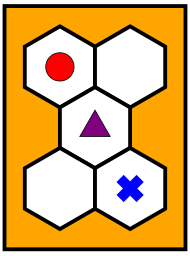

In [4]:
#@title Game Code

# Possible Actions
class Actions(Enum):
    UPRIGHT = "UR"
    RIGHT = "R"
    DOWNRIGHT = "DR"
    DOWNLEFT = "DL"
    LEFT = "L"
    UPLEFT = "UL"
    PICKUP = "Pickup"

# Movements
change = {
    Actions.UPRIGHT : (-1, 1),
    Actions.RIGHT : (0, 2),
    Actions.DOWNRIGHT : (1, 1),
    Actions.DOWNLEFT : (1, -1),
    Actions.LEFT : (0, -2),
    Actions.UPLEFT : (-1, -1),
    Actions.PICKUP : (0, 0),
}
change_str = {action.value: change[action] for action in Actions}
def add(a, b):
    return a[0] + b[0], a[1] + b[1]

@dataclass
class Board:
    grid: List[str]
    player_pos: Tuple[int, int]
    flag_pos: Tuple[int, int]
    wall_pos:List[Tuple[int, int]]
    key_pos:Optional[Tuple[int, int]]

    def move(self, action: Actions) -> 'Board':
        "Move by creating a new board."
        d_m = change[action]
        if action == Actions.PICKUP:
            if self.player_pos == self.key_pos:
                return Board(self.grid, self.player_pos, self.flag_pos, self.wall_pos, None)
            else:
                return self

        new_player_pos = add(self.player_pos, d_m)
        # Out of bounds
        if new_player_pos[0] < 0 or new_player_pos[0] >= len(self.grid):
            return self
        if new_player_pos[1] < 0 or new_player_pos[1] >= len(self.grid[0]):
            return self
        # Can't move through walls
        if self.grid[new_player_pos[0]][new_player_pos[1]] == 'W':
            return self

        new_grid = [row[:] for row in self.grid] # Create a copy of the grid
        new_grid[self.player_pos[0]][self.player_pos[1]] = '.'
        new_grid[new_player_pos[0]][new_player_pos[1]] = '@'
        return Board(new_grid, new_player_pos, self.flag_pos, self.wall_pos, self.key_pos)

    def __str__(self) -> str:
        return '\n'.join(''.join(row) for i, row in enumerate(self.grid))

    @classmethod
    def create_empty_board(cls, size: Tuple[int, int], key_pos, flag_pos, init, wall_pos) -> 'Board':
        grid = [['.' if i % 2 == j % 2  else " " for i in range(size[1])] for j in range(size[0])]
        player_pos = init
        flag_pos = flag_pos
        grid[player_pos[0]][player_pos[1]] = '@'
        grid[flag_pos[0]][flag_pos[1]] = 'P'
        grid[key_pos[0]][key_pos[1]] = 'K'
        for pos in wall_pos:
            grid[pos[0]][pos[1]] = 'W'
        return cls(grid, player_pos, flag_pos, wall_pos, key_pos)

class Game:
    def __init__(self, init, flag, walls, key, boundary):
        "Create the version of the game that the AI sees."
        self.boundary = boundary
        self.board = Board.create_empty_board(boundary, key, flag, init, walls)
        self.original = self.board
        self.actions = []

    def move(self, action):
        self.board = self.board.move(action)
        self.actions.append(action)

    @property
    def walls(self):
        return self.board.wall_pos

    def __repr__(self) -> str:
        walls = ",".join(map(str, self.board.wall_pos))
        return f"Game(init={self.board.player_pos}, flag={self.board.flag_pos}, walls= {self.board.wall_pos}, boundary= {self.boundary}, key= {self.board.key_pos})"

# This is the version of move that the AI can see.
def move(game, action, old_pos):
    # ACTIONS (must be legal)
    game.move(Actions(action))
    offset = change_str[action]
    pos = (old_pos[0] + offset[0], old_pos[1] + offset[1])
    assert 0 <= pos[0] < game.boundary[0]
    assert 0 <= pos[1] < game.boundary[1]
    assert pos not in game.walls
    if action == "PU":
        assert pos == game.key
    return pos

We can look at the board by drawing it.

In [5]:
#@title Drawing code
def draw_board(grid, num=0, return_bytes=False):
    hex = regular_polygon(6, 1).rotate_by(1/12).line_width(0.5).fill_color(Color("white"))
    w = hex.get_envelope().width
    canvas = empty()
    for r, b in enumerate(grid):
        def show(v):
            if v == ".":
                return hex
            if v == "@":
                return hex + circle(0.35).fill_color(Color("red"))
            if v == "P":
                x = rectangle(0.25, 0.7).fill_color(Color("blue")).line_width(0)
                return hex + (x.rotate_by(0.25/2) + x.rotate_by(-0.25/2))
            if v == "K":
                return hex + triangle(0.75).fill_color(Color("purple"))
            if v == "W":
                return hex.fill_color(Color("black"))
            if v ==" ":
                return hex
        row = hcat(show(v) for i, v in enumerate(b[1 if r %2 else 0::2]))
        canvas += row.translate(w * 0.5 if r%2 else 0, 1.5 * r)
    canvas = canvas.center_xy().frame(0.5)
    canvas = rectangle(canvas.get_envelope().width, canvas.get_envelope().height).line_width(0.5).fill_color(Color("orange")) + canvas
    canvas.render(f"pic{num}.png", 256)
    if return_bytes:
        with open(f"pic{num}.png", "rb") as f:
            return f.read()
    #else return the chalk diagram
    return canvas



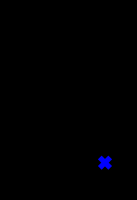

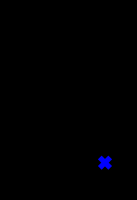

In [6]:
game = Game(boundary=(5, 5), key=(0, 2), flag=(4, 4), init=(0, 0), walls=[(2, 2)])
display(draw_board(game.board.grid))
move(game, "DR", (0,0))
display(draw_board(game.board.grid))

## Prompt Code

The puzzle is to write prompt code to make the model accomplish this task. We have provided some scaffolding code for you. The code creates:

* A header for describing the game.
* A function `make_fun` that shows the AI how to move in code.
* A footer to describe the final game board that you want the mode to solve.

You can fill this in a watch how the model moves around.

In [92]:
#@title Make the Prompt
def make_fun(board, actions):
    "This function generates python code for few-shot examples"
    out = tab + "p = " + str(board.player_pos)
    for i, action in enumerate(actions):
        new_board = board.move(action)
        out += f"""
    p = move(b, "{action.value}", p)"""
        board = new_board
    return out

ex = 0
def prompt(game):
    """
    You should fill these sections out to teach the AI how to play the game.

    Or you may do your own thing :)
    """
    print(f"""
# GAME DESCRIPTION:
# The following is part of a python script, where there is a player 'p', on a
# hexagonal grid, represented by a GameBoard 'b' (assume that the top left grid
# cell is [0,0]). The goal is for the player to reach the flag somewhere in the
# grid, but before the player can do so, they need to first collect the key.
# The picture of the grid is given above, shows the GameBoard that can be
# represented by {repr(game)}.
# Other constraints include that the player cannot move outside the boundaries
# of the GameBoard, the player cannot move into a wall and as mentioned, can only
# complete the goal, by moving to the flag after collecting the key.

# ACTION DESCRIPTION:
# These are the actions that the player 'p' can take.
# The variable `change_str` shows what happens to the (x,y) position of the player
# when a specific action is taken.
change_str = {change_str}

# For eg, if player at (0, 0) moves 'R', then the player moves to (0, 2).
# The boundary constraint tells us that positions where x or y is negative is
# not allowed and will not executed correctly.

# Here 'UR' = 'Upper Right', 'R' = 'Right','DR' = 'Down Right',
# 'DL' = 'Down Left','L' = 'Left', 'UL' = 'Upper Left' and the action 'Pickup'
# can only be performed when the player position is directly over the key's
# position.

{inspect.getsource(move)}
""")
    print(f"""
# Comments for the function below
#
#
#
# - Start: (0,0), Key: (1,1), Flag: (2,2)
# - Obstacle: Wall at (2,0)
# - Boundary: (3,3) (implies 0-2 for coordinates)
# - Rules: Stay in bounds, avoid walls, get key before flag.
#
# Solution Strategy:
# The core idea is to navigate from the start to the key, pick it up,
# and then proceed from the key's location to the flag.
#
# Move Sequence Explanation (and a critical assumption):
# The provided sequence is:
# 1. `p = move(b, "DR", p)`: Moves from (0,0) to the key at (1,1).
#    - For this to work, the "DR" (Down-Right) move must be interpreted
#      by the `Game` as a coordinate shift of (+1, +1). So, (0,0) + DR -> (1,1).
#
# 2. `p = move(b, "Pickup", p)`: At (1,1), picks up the key.
#    - Player now has the key; position is still (1,1).
#
# 3. `p = move(b, "DR", p)`: Moves from (1,1) to the flag at (2,2).
#    - Using the same "DR" interpretation: (1,1) + DR -> (2,2).
""")

    def example(game, actions):
        """
        This code makes a few shot example. You don't need to edit it.
        """
        global ex
        ex += 1
        print(f"""
#-------------
# EXAMPLE:
def example{ex}():
    b = {repr(game)}
{make_fun(game.board, actions)}
    return b
# ------------
""")

    # Create a few shot example (you may not need this)
    board = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[(2, 0)])
    actions = [Actions.DOWNRIGHT, Actions.PICKUP, Actions.DOWNRIGHT]
    example(board, actions)


    print(f"""
# The example functions then have the set of moves to first pickup the key and
# then move to the flag. There cannot be any illegal moves that make the player
# exit the grid (i.e player(x,y) > boundary(x,y)) or make player move into a wall.
# (i.e player(x,y) not in walls)
# ---
""")
    print(f"""
# Contraints for this function:", {repr(game)}
# Please fill this in with code like the examples above.
# Add some comments before the function to write the path that the player must
# take to reach the goal, while avoiding walls and staying inside the grid.
# Assume that the definations for Game and Actions and other varibales are done.
# The following function `my_example` instantiates a GameBoard called b with these constraints.
""")


This code lets you make a game and see the output for a prompt for that game. There are easy, medium, and hard games.

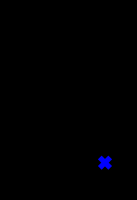


# GAME DESCRIPTION:
# The following is part of a python script, where there is a player 'p', on a
# hexagonal grid, represented by a GameBoard 'b' (assume that the top left grid
# cell is [0,0]). The goal is for the player to reach the flag somewhere in the
# grid, but before the player can do so, they need to first collect the key.
# The picture of the grid is given above, shows the GameBoard that can be 
# represented by Game(init=(0, 0), flag=(4, 4), walls= [(1, 1)], boundary= (5, 5), key= (3, 1)).
# Other constraints include that the player cannot move outside the boundaries
# of the GameBoard, the player cannot move into a wall and as mentioned, can only
# complete the goal, by moving to the flag after collecting the key.

# ACTION DESCRIPTION:
# These are the actions that the player 'p' can take.
# The variable `change_str` shows what happens to the (x,y) position of the player
# when a specific action is taken.
change_str = {'UR': (-1, 1), 'R': (0, 2), 'DR': (1, 1), 'DL': (1, -

In [93]:
# Easy
# game = Game(boundary=(3, 3), key=(1, 1), flag=(2, 2), init=(0, 0), walls=[])

# Medium
game = Game(boundary=(5, 5), key=(3, 1), flag=(4, 4), init=(0, 0), walls=[(1, 1)])

# Hard (This is the main one)
# game = Game(boundary=(8, 15), key=(3, 1), flag=(7, 13), init=(0, 0), walls=[(2, 2), (1, 1), (5, 3), (1, 11), (5, 5), (6, 6), (6, 10), (2, 6), (4, 12)])

# Evil
# game = Game(boundary=(8, 15), key=(5, 1), flag=(7, 13), init=(0, 0), walls=[(2, 2), (3, 3), (4, 2), (1, 1), (2, 4), (7, 11), (5, 3), (1, 11), (5, 5), (6, 6), (6, 10), (2, 6), (4, 12)])

display(draw_board(game.board.grid))
f = io.StringIO()
with redirect_stdout(f):
    ex = 0
    prompt(game)
my_prompt = f.getvalue()
print(my_prompt)

In [73]:
# Run an LLM on the text-only prompt
for prefix in start_text(my_prompt):
    prefix = prefix.replace("```python", "").replace("```", "")
print("Done!!")

```python
# Comments for the function below:
#
# Start: (0,0), Key: (3,1), Flag: (4,4)
# Obstacle: Wall at (1,1)
# Boundary: (5,5) (implies 0-4 for coordinates)
# Rules: Stay in bounds, avoid walls, get key before flag.
#
# Solution Strategy:
# The core idea is to navigate from the start to the key, pick it up,
# and then proceed from the key's location to the flag. We will make sure to avoid
# the wall at (1, 1)
#
# Move Sequence Explanation:
# 1. R: Moves from (0,0) to (0,2)
# 2. DR: Moves from (0,2) to (1,3)
# 3. DL: Moves from (1,3) to (2,2)
# 4. DR: Moves from (2,2) to (3,3)
# 5. L: Moves from (3,3) to (3,1), which is the Key.
# 6. Pickup: Pick up the key at (3,1)
# 7. UR: Moves from (3,1) to (2,2)
# 8. DR: Moves from (2,2) to (3,3)
# 9. DR: Moves from (3,3) to (4,4), which is the Flag.

def my_example():
    b = Game(init=(0, 0), flag=(4, 4), walls= [(1, 1)], boundary= (5, 5), key= (3, 1))
    p = (0, 0)
    p = move(b, "R", p)
    p = move(b, "DR", p)
    p = move(b, "DL", p)
  

In [77]:
# Run an LLM on the multimodal prompt with the board image.
board_img = draw_board(game.board.grid, return_bytes=True)
for prefix in start_multimodal(my_prompt, imgs=[board_img]):
    prefix = prefix.replace("```python", "").replace("```", "")
print("Done!!")

```python
# Comments for my_example function:
#
# - Start: (0,0), Key: (3,1), Flag: (4,4)
# - Obstacle: Wall at (1,1)
# - Boundary: (5,5) (implies 0-4 for coordinates)
# - Rules: Stay in bounds, avoid walls, get key before flag.
#
# Solution Strategy:
# The core idea is to navigate from the start to the key, pick it up,
# and then proceed from the key's location to the flag.  We need to carefully
# avoid the wall at (1,1).
#
# Move Sequence Explanation:
# 1. Start (0,0) -> R -> (0,2)
# 2. (0,2) -> DR -> (1,3)
# 3. (1,3) -> DL -> (2,2)
# 4. (2,2) -> DR -> (3,3)
# 5. (3,3) -> L -> (3,1) (key)
# 6. (3,1) -> Pickup
# 7. (3,1) -> DR -> (4,2)
# 8. (4,2) -> R -> (4,4) (flag)

def my_example():
    b = Game(init=(0, 0), flag=(4, 4), walls= [(1, 1)], boundary= (5, 5), key= (3, 1))
    p = (0, 0)
    p = move(b, "R", p)
    p = move(b, "DR", p)
    p = move(b, "DL", p)
    p = move(b, "DR", p)
    p = move(b, "L", p)
    p = move(b, "Pickup", p)
    p = move(b, "DR", p)
    p = move(b, "R", p)
 

0 : b = Game(init=(0, 0), flag=(4, 4), walls= [(1, 1)], boundary= (5, 5), key= (3, 1))


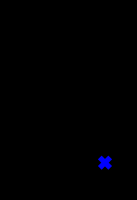

1 : p = (0, 0)


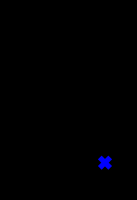

2 : p = move(b, "R", p)


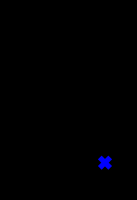

3 : p = move(b, "DR", p)


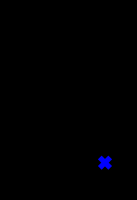

4 : p = move(b, "DL", p)


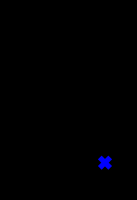

5 : p = move(b, "DR", p)


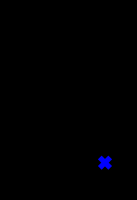

6 : p = move(b, "L", p)


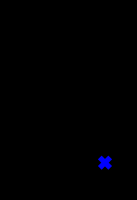

7 : p = move(b, "Pickup", p)


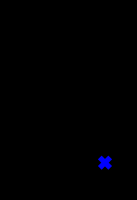

8 : p = move(b, "DR", p)


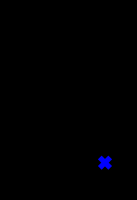

9 : p = move(b, "R", p)


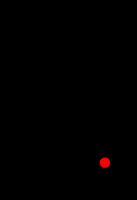

In [78]:
i = 0
q = {}
encountered_function_defination = False
for ps in prefix.splitlines():
    ps = ps.strip()
    if "def" in ps or "return" in ps or ps.startswith("#") or len(ps)==0:
        continue
    try:
        print(f"{i} : {ps}")
        #exec(ps+f"\ndisplay(draw_board(b.board.grid))")
        exec(ps + "\nq['board'] = b")
        display(draw_board(q['board'].board.grid, i))
        i += 1
    except:
        print("Illegal Move Made!!!")
        break

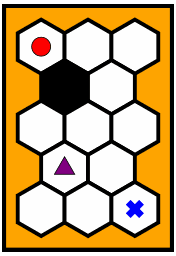

In [79]:
# Animate the outputs as a GIF
def animate(i):
    images = []
    for idx in range(i):
        images.append(imageio.v2.imread(f"pic{idx}.png"))
    return imageio.v2.mimsave('movie.gif', images, **{ 'duration': 500 })
animate(i)
display(Image("movie.gif"))

In [76]:
# Print the number of tokens used
print("Input Tokens:", num_tokens_from_string(my_prompt))
print("Output Tokens:", num_tokens_from_string(prefix))

Input Tokens: 1176
Output Tokens: 471


In [107]:
# Ensure these imports are present. Some might be new.
from collections import deque
import random
# Assuming List, Tuple, Optional, Dict from typing are already imported if you use type hints extensively.
# If not, you might need:
# from typing import List, Tuple, Optional, Dict

# --- Code for the new Jupyter Notebook cell ---

# Helper: Movement deltas for pathfinding (excludes PICKUP)
# This assumes 'change' and 'Actions' are defined in a previous cell.
# If you get a NameError here, ensure the cell defining Actions and change has been run.
try:
    _PATH_MOVEMENT_DELTAS = [delta for action_enum, delta in change.items() if action_enum != Actions.PICKUP]
except NameError as e:
    print(f"Error: Required variables 'change' or 'Actions' not found. Make sure they are defined and the cell executed. Details: {e}")
    _PATH_MOVEMENT_DELTAS = [] # Default to empty to avoid further errors, but generation will fail.


def bfs_path_exists(boundary: Tuple[int, int],
                    start_node: Tuple[int, int],
                    end_node: Tuple[int, int],
                    walls: List[Tuple[int, int]],
                    movement_deltas: List[Tuple[int, int]]) -> bool:
    """Checks if a path exists from start_node to end_node using BFS."""
    rows, cols = boundary
    if not (0 <= start_node[0] < rows and 0 <= start_node[1] < cols and \
            0 <= end_node[0] < rows and 0 <= end_node[1] < cols):
        return False # Start or end node out of bounds

    if start_node in walls or end_node in walls:
        return False

    if start_node == end_node:
        return True

    queue = deque([start_node])
    visited = {start_node}

    while queue:
        current_r, current_c = queue.popleft()

        for dr, dc in movement_deltas:
            next_r, next_c = current_r + dr, current_c + dc
            next_pos = (next_r, next_c)

            if 0 <= next_r < rows and 0 <= next_c < cols and \
               next_pos not in visited and next_pos not in walls:
                if next_pos == end_node:
                    return True
                visited.add(next_pos)
                queue.append(next_pos)
    return False

def get_random_distinct_positions(boundary: Tuple[int, int],
                                  num_positions: int,
                                  exclusions: Optional[List[Tuple[int, int]]] = None) -> List[Tuple[int, int]]:
    """Generates a list of unique random positions within bounds, avoiding exclusions."""
    rows, cols = boundary
    all_possible_positions = []
    current_exclusions = set(exclusions) if exclusions else set()

    for r in range(rows):
        for c in range(cols):
            pos = (r, c)
            if pos not in current_exclusions:
                all_possible_positions.append(pos)

    if len(all_possible_positions) < num_positions:
        raise ValueError(f"Cannot select {num_positions} distinct positions from the available {len(all_possible_positions)} spots after exclusions.")

    return random.sample(all_possible_positions, k=num_positions)


def level_generator(difficulty_name: str, n_levels: int) -> List['Game']: # Assuming Game type is known
    """
    Generates 'n_levels' variations of a game level for the given 'difficulty_name'.
    Each generated level is guaranteed to be solvable.
    Relies on 'Game', 'Board', 'Actions', 'change' being defined from previous cells.
    """
    generated_games: List[Game] = [] # Use 'Game' if it's globally known

    difficulty_configs = {
        "easy":   {"boundary": (3, 3), "num_walls_range": (0, 1), "init_pos": (0, 0)},
        "medium": {"boundary": (5, 5), "num_walls_range": (2, 4), "init_pos": (0, 0)},
        "hard":   {"boundary": (8, 15), "num_walls_range": (7, 12), "init_pos": (0, 0)},
        "evil":   {"boundary": (8, 15), "num_walls_range": (12, 18), "init_pos": (0, 0)},
        "custom_small_sparse": {"boundary": (6,8), "num_walls_range": (2,4), "init_pos": (0,0)},
        "custom_large_dense": {"boundary": (10,20), "num_walls_range": (20,35), "init_pos": None}, # Example with random init
    }

    if not _PATH_MOVEMENT_DELTAS:
        print("Critical Error: _PATH_MOVEMENT_DELTAS is empty. Pathfinding will not work. Ensure 'Actions' and 'change' are correctly defined and processed.")
        return []

    if difficulty_name not in difficulty_configs:
        print(f"Error: Unknown difficulty: '{difficulty_name}'. "
                         f"Choose from {list(difficulty_configs.keys())}")
        return []

    config = difficulty_configs[difficulty_name]
    boundary = config["boundary"]
    rows, cols = boundary
    min_walls, max_walls = config["num_walls_range"]
    fixed_init_pos = config.get("init_pos")

    max_generation_attempts_per_level = 100

    for i in range(n_levels):
        level_generated_successfully = False
        for attempt in range(max_generation_attempts_per_level):
            try:
                # 1. Determine Player, Key, and Flag positions
                if fixed_init_pos:
                    if not (0 <= fixed_init_pos[0] < rows and 0 <= fixed_init_pos[1] < cols):
                        print(f"Warning: Fixed init_pos {fixed_init_pos} is out of boundary {boundary} for difficulty {difficulty_name}. Using random init.")
                        current_init_pos = get_random_distinct_positions(boundary, 1)[0]
                    else:
                        current_init_pos = fixed_init_pos
                    pos_list = get_random_distinct_positions(boundary, 2, exclusions=[current_init_pos])
                    current_key_pos = pos_list[0]
                    current_flag_pos = pos_list[1]
                else:
                    pos_list = get_random_distinct_positions(boundary, 3)
                    current_init_pos = pos_list[0]
                    current_key_pos = pos_list[1]
                    current_flag_pos = pos_list[2]

                # 2. Generate Wall positions
                num_walls_to_generate = random.randint(min_walls, max_walls)
                exclusions_for_walls = [current_init_pos, current_key_pos, current_flag_pos]

                potential_wall_spots = []
                for r_wall in range(rows):
                    for c_wall in range(cols):
                        if (r_wall, c_wall) not in exclusions_for_walls:
                            potential_wall_spots.append((r_wall, c_wall))

                if len(potential_wall_spots) < num_walls_to_generate:
                    current_walls = potential_wall_spots
                else:
                    current_walls = random.sample(potential_wall_spots, k=num_walls_to_generate)

                # 3. Validate Solvability
                path_to_key_exists = bfs_path_exists(boundary, current_init_pos, current_key_pos,
                                                     current_walls, _PATH_MOVEMENT_DELTAS)
                path_key_to_flag_exists = bfs_path_exists(boundary, current_key_pos, current_flag_pos,
                                                          current_walls, _PATH_MOVEMENT_DELTAS)

                if path_to_key_exists and path_key_to_flag_exists:
                    # Assumes your Game class __init__ is: Game(init, flag, walls, key, boundary)
                    game_instance = Game(init=current_init_pos,
                                         flag=current_flag_pos,
                                         walls=current_walls,
                                         key=current_key_pos,
                                         boundary=boundary)
                    generated_games.append(game_instance)
                    level_generated_successfully = True
                    # print(f"Successfully generated level {i+1}/{n_levels} for '{difficulty_name}' (attempt {attempt+1}).") # Optional print
                    break
            except ValueError as e: # Catch errors from get_random_distinct_positions (e.g. not enough space)
                # print(f"Attempt {attempt+1} for level {i+1} failed: {e}") # Optional print
                continue # Try next attempt
            except Exception as e: # Catch any other unexpected errors during generation attempt
                print(f"Unexpected error during level generation attempt {attempt+1} for level {i+1}: {e}")
                continue

        if not level_generated_successfully:
            print(f"Warning: Failed to generate solvable level {i+1}/{n_levels} for '{difficulty_name}' "
                  f"after {max_generation_attempts_per_level} attempts. Parameters might be too restrictive.")

    return generated_games

In [113]:
games = level_generator("medium", 5)

In [117]:
results = []
for game in games:
    f = io.StringIO()
    with redirect_stdout(f):
        ex = 0
        prompt(game)
    my_prompt = f.getvalue()
    for prefix in start_text(my_prompt):
        prefix = prefix.replace("```python", "").replace("```", "")
    results.append(prefix)

```python
# Path:
# 1. Start at (0, 0)
# 2. Move DR to (1, 1) to pick up the key.
# 3. Pick up the key.
# 4. Move UR to (0, 2).
# 5. Move R to (0, 4).
# 6. Move DR to (1, 3).
# 7. Move DR to (2, 2).
# 8. Move DR to the flag at (3, 1).

def my_example():
    b = Game(init=(0, 0), flag=(3, 1), walls= [(2, 2), (4, 3), (2, 3), (2, 1)], boundary= (5, 5), key= (1, 1))
    p = (0, 0)
    p = move(b, "DR", p) # Move to (1, 1)
    p = move(b, "Pickup", p) # Pick up the key at (1, 1)
    p = move(b, "UR", p) # Move to (0, 2)
    p = move(b, "R", p) # Move to (0, 4)
    p = move(b, "DR", p) # Move to (1, 3)
    p = move(b, "DR", p) # Move to (2, 2)
    p = move(b, "DR", p) # Move to (3, 1) - the flag
    return b
``````python
# Solution Strategy:
# The core idea is to navigate from the start to the key, pick it up,
# and then proceed from the key's location to the flag.
#
# Move Sequence Explanation:
# 1. Move from (0,0) to (1,1) to (2,2) to (3,3) to (2,4).
# 2. Pickup the key at (2,4).
# 3. Move

0 : b = Game(init=(0, 0), flag=(3, 1), walls= [(2, 2), (4, 3), (2, 3), (2, 1)], boundary= (5, 5), key= (1, 1))


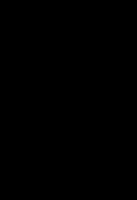

1 : p = (0, 0)


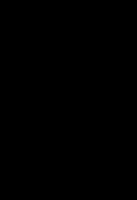

2 : p = move(b, "DR", p) # Move to (1, 1)


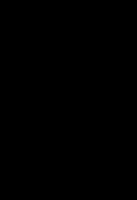

3 : p = move(b, "Pickup", p) # Pick up the key at (1, 1)


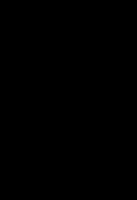

4 : p = move(b, "UR", p) # Move to (0, 2)


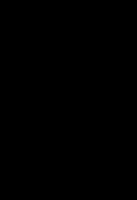

5 : p = move(b, "R", p) # Move to (0, 4)


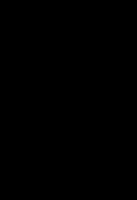

6 : p = move(b, "DR", p) # Move to (1, 3)
Illegal Move Made!!!
0 : b = Game(init=(0, 0), flag=(2, 2), walls= [(4, 2), (1, 2)], boundary= (5, 5), key= (2, 4))


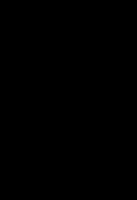

1 : p = (0, 0)


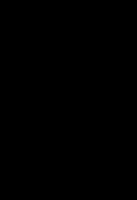

2 : p = move(b, "DR", p, p)
Illegal Move Made!!!
0 : b = Game(init=(0, 0), flag=(3, 3), walls= [(2, 0), (4, 2)], boundary= (5, 5), key= (4, 0))


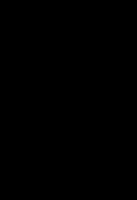

1 : p = (0, 0)


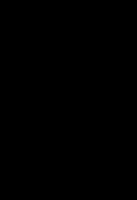

2 : p = move(b, "R", p)


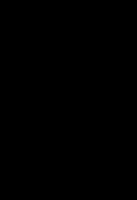

3 : p = move(b, "R", p)


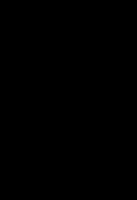

4 : p = move(b, "R", p)
Illegal Move Made!!!
0 : b = Game(init=(0, 0), flag=(4, 2), walls= [(1, 1), (0, 3), (4, 4)], boundary= (5, 5), key= (0, 2))


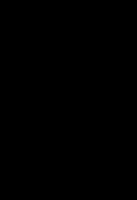

1 : p = (0, 0)


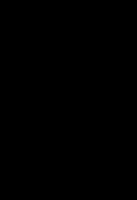

2 : p = move(b, "R", p) # Move from (0,0) to (0,2)


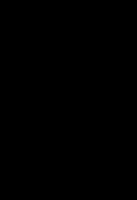

3 : p = move(b, "Pickup", p) # Pickup key at (0,2)


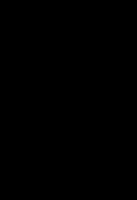

4 : p = move(b, "DR", p) # Move from (0,2) to (1,3)


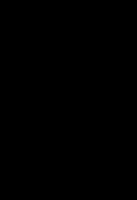

5 : p = move(b, "UL", p) # Move from (1,3) to (2,2)


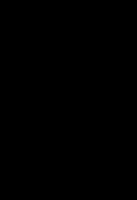

6 : p = move(b, "DR", p) # Move from (2,2) to (3,3)


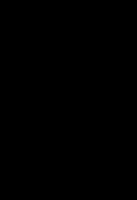

7 : p = move(b, "UR", p) # Move from (3,3) to (4,2)


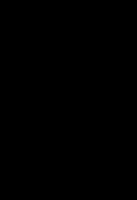

0 : b = Game(init=(0, 0), flag=(1, 3), walls= [(0, 2), (2, 1), (3, 4), (4, 3)], boundary= (5, 5), key= (4, 4))


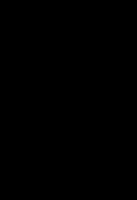

1 : p = (0, 0)


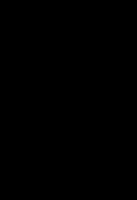

2 : p = move(b, "R", p) # (0,2) - Invalid
Illegal Move Made!!!
4 games contained illegal moves.


In [118]:
illegal_moves = 0
for res in results:
    i = 0
    q = {}
    encountered_function_defination = False
    for ps in res.splitlines():
        ps = ps.strip()
        if "def" in ps or "return" in ps or ps.startswith("#") or len(ps)==0:
            continue
        try:
            print(f"{i} : {ps}")
            #exec(ps+f"\ndisplay(draw_board(b.board.grid))")
            exec(ps + "\nq['board'] = b")
            display(draw_board(q['board'].board.grid, i))
            i += 1
        except:
            illegal_moves += 1
            print("Illegal Move Made!!!")
            break

print(f"{illegal_moves} games contained illegal moves.")